In [1]:
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import itertools
import collections
import matplotlib.pyplot as plt

# 读取数据
df = pd.read_csv("Chinese_Names_Corpus_Gender（120W）.txt", header=2) # 读成了dataframe
df

,dict,sex
0,阿安,男
1,阿彬,未知
2,阿斌,男
3,阿滨,男
4,阿冰,女
...,...,...
1145004,佐腾,男
1145005,佐威,男
1145006,佐为,男
1145007,佐樱,女


In [2]:
df = df[df.sex != "未知"] # 去除性别中为“未知”的
names = df["dict"].values # 选只有名字的一列

# 计算单字频率
chars = [list(name) for name in names] # 拆成单字[['阿', '安'],['阿', '斌']]
chars_flatten = list(itertools.chain(*chars)) # 变成一个列表
freq = collections.Counter(chars_flatten) # 对列表里相同的进行计数
freq = pd.DataFrame(freq.items(), columns=["char", "freq"]) # 将计数后列表重新生成datastructure
freq = freq.sort_values(by="freq", ascending=False) # 排序
freq

,char,freq
636,王,50390
926,李,49078
1086,张,47089
1203,陈,41512
1394,刘,39986
...,...,...
2170,墙,1
2171,棱,1
2172,禺,1
2173,据,1


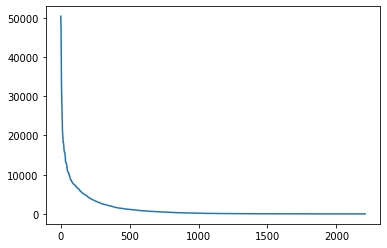

In [3]:
# 频率分布
char_rank = np.arange(freq.shape[0])
char_freq = freq["freq"].values
plt.plot(char_rank, char_freq)

In [4]:
# 由常见字组成的名字数据
dict_size = 500
dict = list(freq["char"].values[:dict_size]) # 只选第一列, 是一个汉字列表
dict_set = set(dict) # 为什么变成集合？
filtered = list(filter(lambda item: set(item[1]).issubset(dict_set), enumerate(names))) # A.issubset(B) A是否是B的子集,filter配合生成器，两个字都要在前500中
ind = [idx for idx, name in filtered] # 选择满足条件的序号
dat = df.iloc[ind] # 选出序号满足条件的值
dat["y"] = np.where(dat["sex"] == "男", 0, 1)
dat # 只剩下名字在500高频字列表中的名字

C:\Users\DELL\AppData\Local\Temp\ipykernel_17880\3907298184.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat["y"] = np.where(dat["sex"] == "男", 0, 1)


,dict,sex,y
401,艾爱,女,1
402,艾爱国,男,0
403,艾爱平,女,1
404,艾安,男,0
405,艾白,女,1
...,...,...,...
1144983,左宗明,男,0
1144984,左宗申,男,0
1144985,左宗胜,男,0
1144986,左宗堂,男,0


In [5]:
# 划分训练集和测试集
train = dat.sample(n=10000, random_state=123) #是一个df
test = dat.sample(n=1000, random_state=321)

# One-hot 编码 # 给一个字符知道字符在字典中是第几个
def char2index(char):
    return dict.index(char) # dict是排序后前500个列表

def name2index(name):
    return [char2index(char) for char in name] # 几个字都变成序号

def name2tensor(name):
    tensor = torch.zeros(len(name), 1, dict_size)
    for i, char in enumerate(name):
        tensor[i, 0, char2index(char)] = 1 # tensot是一个三维数组 1*d
    return tensor

char2index("李")

1

In [6]:
name2index("李兴")

[1, 76]

In [9]:
name2tensor("李兴")

tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [10]:
# 建立模型 RNN
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, 1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), dim=1)
        hidden = torch.tanh(self.i2h(combined))
        output = torch.sigmoid(self.h2o(hidden))
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [10]:
# 测试模型输入输出
n_hidden = 128
rnn = RNN(dict_size, n_hidden)
input = name2tensor("李兴")
hidden = rnn.init_hidden()
output, next_hidden = rnn(input[0], hidden)
print(output)
print(next_hidden)

tensor([[0.5039]], grad_fn=<SigmoidBackward0>)
tensor([[ 3.9781e-02,  2.8147e-02, -3.6969e-02,  1.3793e-02, -5.8002e-02,
         -1.4093e-02, -4.9785e-02,  5.8509e-02,  1.9775e-02, -3.1678e-03,
          2.2597e-02, -2.8383e-02,  1.5317e-02, -7.8083e-03,  3.6871e-03,
         -2.2734e-02,  2.4379e-02,  2.1663e-02, -3.6015e-02,  1.7164e-02,
          2.6967e-03, -3.3535e-02, -6.8762e-02,  4.8796e-03,  1.1621e-02,
          2.0426e-02,  1.7782e-02,  1.7175e-02, -3.1590e-02,  3.8382e-02,
          6.1524e-02,  1.8383e-02,  2.2076e-02, -2.0587e-02,  2.2252e-02,
          2.2557e-02, -1.6937e-02, -2.0218e-02,  3.8881e-03, -2.5070e-02,
         -7.1744e-02, -7.0943e-03,  5.6245e-02,  1.5940e-02,  3.1001e-02,
          2.4812e-02,  6.1076e-02, -4.8246e-02, -3.3198e-02, -9.2560e-03,
          3.8047e-02,  3.5928e-02, -4.0104e-02, -3.4599e-02, -4.1972e-02,
         -1.7890e-02,  1.0700e-02, -4.8431e-02,  9.9346e-03, -1.0565e-02,
         -5.0752e-02,  3.4963e-02,  1.5125e-02, -1.9436e-03, -3.8

In [11]:
hidden = next_hidden
output, next_hidden = rnn(input[1], hidden)
print(output)
print(next_hidden)

tensor([[0.5067]], grad_fn=<SigmoidBackward0>)
tensor([[-0.0138, -0.0338, -0.0071, -0.0495, -0.0489,  0.0478, -0.0397,  0.0367,
          0.0769, -0.0320, -0.0305, -0.0017, -0.0545,  0.0306,  0.0659,  0.0190,
          0.0228,  0.0104, -0.0789,  0.0160,  0.0141, -0.0240, -0.0419, -0.0370,
          0.0067,  0.0328,  0.0679,  0.0059, -0.0010,  0.0177,  0.0046,  0.0168,
          0.0300, -0.0210, -0.0067,  0.0691,  0.0207, -0.0203, -0.0077,  0.0113,
         -0.0617,  0.0519,  0.0628,  0.0387,  0.0276,  0.0155, -0.0054, -0.0096,
         -0.0235,  0.0400, -0.0412, -0.0157, -0.0056,  0.0225, -0.0019, -0.0065,
          0.0347, -0.0210,  0.0049, -0.0299, -0.0184, -0.0031,  0.0002, -0.0479,
         -0.0435,  0.0440,  0.0037, -0.0599, -0.0230, -0.0415,  0.0002,  0.0056,
          0.0170,  0.0314,  0.0086, -0.0421,  0.0425,  0.0025,  0.0288,  0.0041,
          0.0012, -0.0464, -0.0210, -0.0488,  0.0551,  0.0270,  0.0233, -0.0429,
          0.0260, -0.0143,  0.0052,  0.0071, -0.0342,  0.0514,

In [12]:
# 正式模型训练
np.random.seed(123)
torch.random.manual_seed(123)

n = train.shape[0]
n_hidden = 64 # 隐藏层长度
nepoch = 5
bs = 100

rnn = RNN(dict_size, n_hidden) # 字典长度500，隐藏层长度
opt = torch.optim.Adam(rnn.parameters(), lr=0.001) # 优化器
train_ind = np.arange(n) # 训练集标签1~n
losses = []

t1 = time.time()
for k in range(nepoch): # 数据遍历多少次
    np.random.shuffle(train_ind) # 打乱训练集
    # Mini-batch 循环
    for j in range(0, n, bs): # minibatch
        # 建立 mini-batch
        mb = train.iloc[train_ind[j:(j + bs)]] # 选列表中这些行，
        mb_size = mb.shape[0] # 一共多少个名字
        loss = 0.0
        # 对 Mini-batch 中的每个名字进行循环 # 如何计算损失函数 # 对每一个样本点单独写循环
        for i in range(mb_size):
            name = mb["dict"].values[i] # 把名字汉字取出来
            input = name2tensor(name) # 将名字转为tensor，悠悠名字长度的tensor组成
            hidden = rnn.init_hidden()
            y = mb["y"].values[i] # 性别标签
            # 对名字中的每个字进行循环
            for s in range(input.shape[0]):
                output, hidden = rnn(input[s], hidden) # 投一个字进去训练
            loss = loss - y * torch.log(output) - (1.0 - y) * torch.log(1.0 - output) # 对数似然

        loss = loss / mb_size
        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())
        if j // bs % 10 == 0:
            print(f"epoch {k}, batch {j // bs}, loss = {loss.item()}")
t2 = time.time()
print(t2 - t1)

epoch 0, batch 0, loss = 0.7133022546768188
epoch 0, batch 10, loss = 0.6761780381202698
epoch 0, batch 20, loss = 0.6261805891990662
epoch 0, batch 30, loss = 0.5781686305999756
epoch 0, batch 40, loss = 0.5512726902961731
epoch 0, batch 50, loss = 0.5336638689041138
epoch 0, batch 60, loss = 0.5058482885360718
epoch 0, batch 70, loss = 0.5043060779571533
epoch 0, batch 80, loss = 0.44378843903541565
epoch 0, batch 90, loss = 0.38597309589385986
epoch 1, batch 0, loss = 0.3651692569255829
epoch 1, batch 10, loss = 0.3681095838546753
epoch 1, batch 20, loss = 0.27375924587249756
epoch 1, batch 30, loss = 0.24464084208011627
epoch 1, batch 40, loss = 0.28715941309928894
epoch 1, batch 50, loss = 0.3098525106906891
epoch 1, batch 60, loss = 0.28342700004577637
epoch 1, batch 70, loss = 0.24363455176353455
epoch 1, batch 80, loss = 0.2275119423866272
epoch 1, batch 90, loss = 0.22295738756656647
epoch 2, batch 0, loss = 0.22859273850917816
epoch 2, batch 10, loss = 0.1615162491798401
epoc

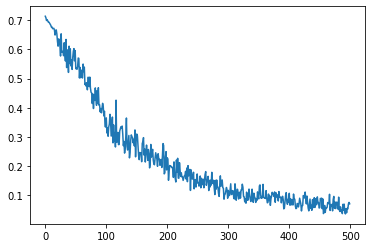

In [13]:
plt.plot(losses)

In [14]:
# 对测试集预测
ntest = test.shape[0]
true_label = test["y"].values
pred = np.zeros(ntest)
rnn.eval()
for i in range(ntest):
    input = name2tensor(test["dict"].values[i])
    hidden = rnn.init_hidden()
    with torch.no_grad():
        for s in range(input.shape[0]):
            output, hidden = rnn(input[s], hidden)
    pred[i] = output.item()
    if i % 100 == 0:
        print(f"processed {i}")
loss = -np.mean(true_label * np.log(pred) + (1.0 - true_label) * np.log(1.0 - pred))
print(loss)
pred_label = (pred > 0.5).astype(int)
print(np.mean(pred_label == true_label))

processed 0
processed 100
processed 200
processed 300
processed 400
processed 500
processed 600
processed 700
processed 800
processed 900
0.07498759074511005
0.979


In [15]:
# 随机取样
np.random.seed(123)
torch.random.manual_seed(123)
ind = np.random.choice(ntest, 10)
ypred = 1 * (pred[ind] > 0.5)
test.iloc[ind]

,dict,sex,y
26087,曹加平,男,0
511395,陆晓光,男,0
770127,王为良,男,0
775388,王兴雷,男,0
691186,孙晓媛,女,1
1075286,郑春霞,女,1
493391,刘子维,男,0
401564,李相亮,男,0
868552,熊晓蕾,女,1
110497,单芳,女,1


In [16]:
# 真实标签
print(test["y"].values[ind])

# 预测标签
print(ypred)

[0 0 0 0 1 1 0 0 1 1]
[0 0 0 0 1 1 0 0 1 1]


In [17]:
names = ["李", "李雪", "李雪峰"]
for name in names:
    input = name2tensor(name)
    hidden = rnn.init_hidden()
    with torch.no_grad():
        for s in range(input.shape[0]):
            output, hidden = rnn(input[s], hidden)
    pred = output.item()
    print(f"namae: {name}, P(female) = {pred}")

namae: 李, P(female) = 0.5191545486450195
namae: 李雪, P(female) = 0.8673224449157715
namae: 李雪峰, P(female) = 0.02042042464017868
